# Data Transforms

In [1]:
import matplotlib.pyplot as plt
from monai.transforms import (
    LoadImaged,
    EnsureChannelFirstd,
    Orientationd,
    Spacingd,
    ScaleIntensityRanged,
    CropForegroundd,
    RandSpatialCropd,
)

TEST_SERIES_COLON = "/Users/joshuabunnell/Projects/data/dicom/ct-colonography_organized/1.3.6.1.4.1.9328.50.4.1/1.3.6.1.4.1.9328.50.4.2"
TEST_SERIES_PED = "/Users/joshuabunnell/Projects/data/dicom/pediatric-ct-seg_organized/1.3.6.1.4.1.14519.5.2.1.52871920226833551870199279497603326842/1.3.6.1.4.1.14519.5.2.1.152462310538135643296361481168522825410"

series_map = {
    "Colonography": TEST_SERIES_COLON,
    "Pediatric": TEST_SERIES_PED,
}

### Load Data

/Users/joshuabunnell/Projects/moco/.venv/lib/python3.12/site-packages/monai/transforms/io/array.py:213: UserWarning: required package for reader ITKReader is not installed, or the version doesn't match requirement.
  warnings.warn(


[Colonography] Original Shape: torch.Size([512, 512, 604])
[Colonography] Max Pixel Value: 3071.0
[Pediatric] Original Shape: torch.Size([512, 512, 182])
[Pediatric] Max Pixel Value: 3100.0


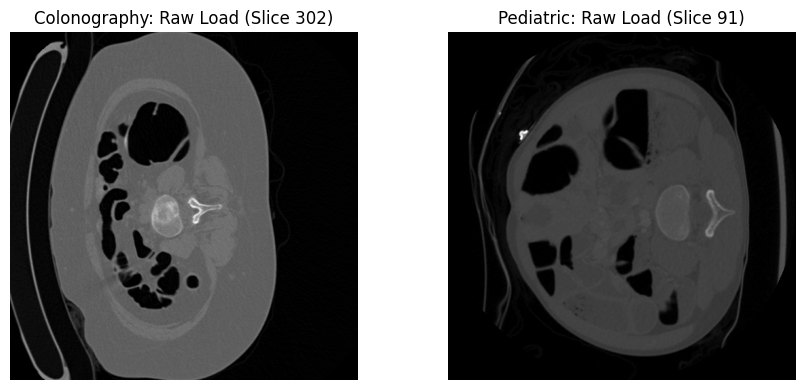

In [2]:
loader = LoadImaged(keys=["image"], reader="ITKReader", image_only=True)
data_by_series = {}

for name, path in series_map.items():
    sample = {"image": path}
    sample = loader(sample)
    data_by_series[name] = sample

    print(f"[{name}] Original Shape: {sample['image'].shape}")
    print(f"[{name}] Max Pixel Value: {sample['image'].max().item()}")

# VISUALIZATION (side-by-side)
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
for ax, (name, sample) in zip(axes, data_by_series.items()):
    image = sample["image"]
    slice_idx = image.shape[-1] // 2
    ax.imshow(image[:, :, slice_idx], cmap="gray")
    ax.set_title(f"{name}: Raw Load (Slice {slice_idx})")
    ax.axis("off")

plt.tight_layout()
plt.show()

### Add Channel

In [3]:
channel_adder = EnsureChannelFirstd(keys=["image"], channel_dim="no_channel")

for name, sample in data_by_series.items():
    updated = channel_adder(sample)
    image = updated["image"]

    # Standardize to [C, H, W, D] for downstream MONAI spatial transforms
    while image.ndim > 4 and image.shape[0] == 1:
        image = image.squeeze(0)
    if image.ndim == 3:
        image = image.unsqueeze(0)

    updated["image"] = image
    data_by_series[name] = updated
    print(f"[{name}] New Shape (Channel First): {data_by_series[name]['image'].shape}")

[Colonography] New Shape (Channel First): torch.Size([1, 512, 512, 604])
[Pediatric] New Shape (Channel First): torch.Size([1, 512, 512, 182])


### Orientation (RAS)

[Colonography] Shape after Orientation: torch.Size([1, 512, 512, 604])
[Pediatric] Shape after Orientation: torch.Size([1, 512, 512, 182])


/Users/joshuabunnell/Projects/moco/.venv/lib/python3.12/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


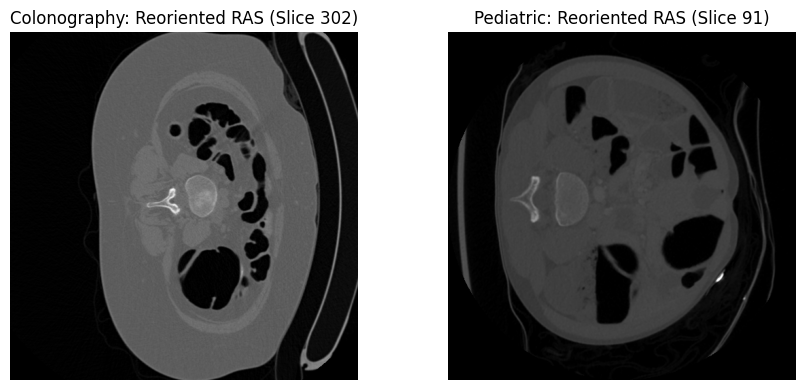

In [4]:
orienter = Orientationd(keys=["image"], axcodes="RAS")

for name, sample in data_by_series.items():
    data_by_series[name] = orienter(sample)
    print(f"[{name}] Shape after Orientation: {data_by_series[name]['image'].shape}")

# VISUALIZATION (side-by-side)
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
for ax, (name, sample) in zip(axes, data_by_series.items()):
    image = sample["image"]
    slice_idx = image.shape[-1] // 2
    ax.imshow(image[0, :, :, slice_idx], cmap="gray")
    ax.set_title(f"{name}: Reoriented RAS (Slice {slice_idx})")
    ax.axis("off")

plt.tight_layout()
plt.show()

### Spacing

[Colonography] Resampled Shape (1mm Isotropic): torch.Size([1, 400, 400, 483])
[Pediatric] Resampled Shape (1mm Isotropic): torch.Size([1, 260, 260, 363])


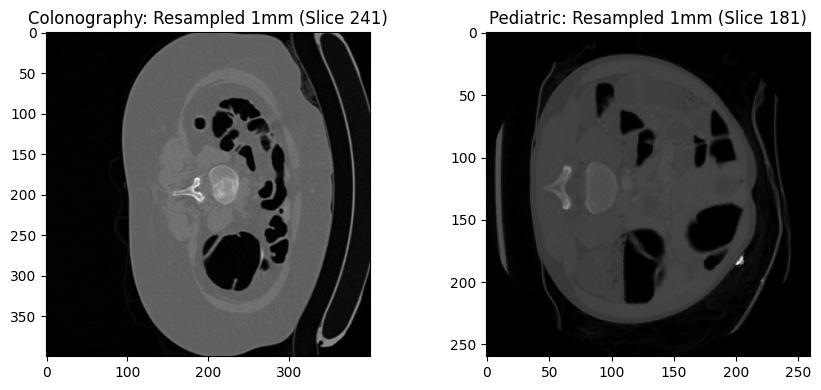

In [5]:
spacer = Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear")

for name, sample in data_by_series.items():
    data_by_series[name] = spacer(sample)
    print(
        f"[{name}] Resampled Shape (1mm Isotropic): {data_by_series[name]['image'].shape}"
    )

# VISUALIZATION (side-by-side)
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
for ax, (name, sample) in zip(axes, data_by_series.items()):
    image = sample["image"]
    slice_idx = image.shape[-1] // 2
    ax.imshow(image[0, :, :, slice_idx], cmap="gray")
    ax.set_title(f"{name}: Resampled 1mm (Slice {slice_idx})")
    ax.axis("on")

plt.tight_layout()
plt.show()

### Windowing

[Colonography] Value Check -> Min: 0.00, Max: 1.00
[Pediatric] Value Check -> Min: 0.00, Max: 1.00


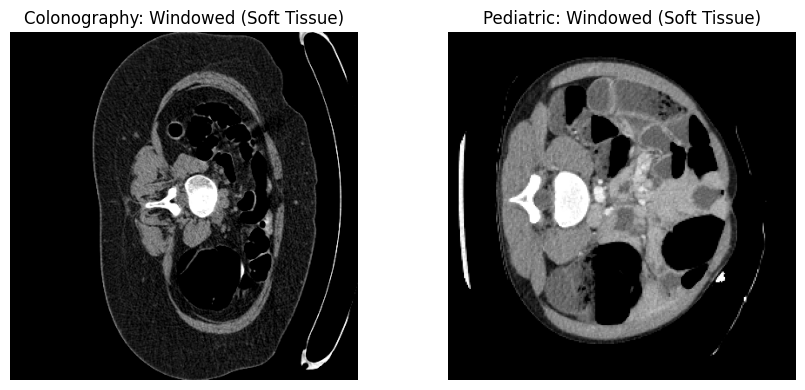

In [6]:
windower = ScaleIntensityRanged(
    keys=["image"], a_min=-150, a_max=250, b_min=0.0, b_max=1.0, clip=True
)

for name, sample in data_by_series.items():
    data_by_series[name] = windower(sample)
    image = data_by_series[name]["image"]
    print(f"[{name}] Value Check -> Min: {image.min():.2f}, Max: {image.max():.2f}")

# VISUALIZATION (side-by-side)
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
for ax, (name, sample) in zip(axes, data_by_series.items()):
    image = sample["image"]
    slice_idx = image.shape[-1] // 2
    ax.imshow(image[0, :, :, slice_idx], cmap="gray")
    ax.set_title(f"{name}: Windowed (Soft Tissue)")
    ax.axis("off")

plt.tight_layout()
plt.show()

[Colonography] Current shape before crop: torch.Size([1, 400, 400, 483])
[Colonography] Final Crop Shape: torch.Size([1, 224, 224, 3])
[Colonography] Tensor Ready for MoCo: torch.Size([3, 224, 224])
[Pediatric] Current shape before crop: torch.Size([1, 260, 260, 363])
[Pediatric] Final Crop Shape: torch.Size([1, 224, 224, 3])
[Pediatric] Tensor Ready for MoCo: torch.Size([3, 224, 224])


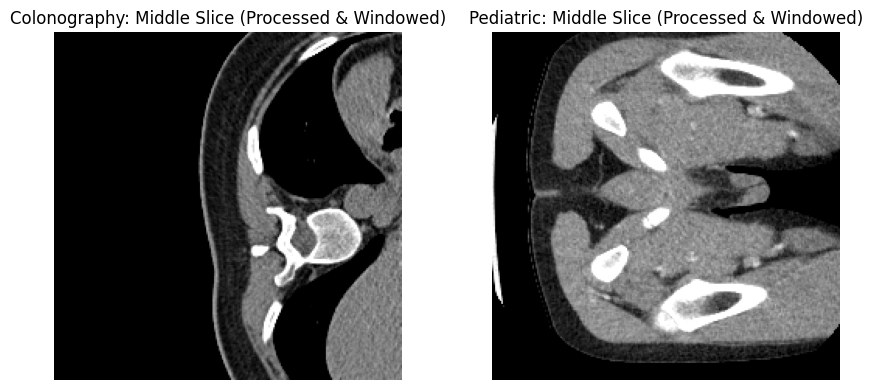

In [7]:
cropper = RandSpatialCropd(keys=["image"], roi_size=(224, 224, 3), random_size=False)
final_tensors = {}

for name, sample in data_by_series.items():
    current_shape = sample["image"].shape
    print(f"[{name}] Current shape before crop: {current_shape}")

    try:
        data_crop = cropper(sample)
        print(f"[{name}] Final Crop Shape: {data_crop['image'].shape}")

        # (1, 224, 224, 3) -> (224, 224, 3) -> (3, 224, 224)
        final_tensor = data_crop["image"][0].permute(2, 0, 1)
        final_tensors[name] = final_tensor
        print(f"[{name}] Tensor Ready for MoCo: {final_tensor.shape}")

    except Exception as e:
        print(f"[{name}] Crop failed. Check dimensions from previous cells. Error: {e}")

# VISUALIZATION (side-by-side middle slice from each processed tensor)
if len(final_tensors) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(9, 4))
    for ax, (name, tensor) in zip(axes, final_tensors.items()):
        ax.imshow(tensor[1, :, :], cmap="gray")
        ax.set_title(f"{name}: Middle Slice (Processed & Windowed)")
        ax.axis("off")

    plt.tight_layout()
    plt.show()